# **Paute Water Balance and Drought Analysis (PARTS 1 to 3)**

## Introduction

Water, a critical resource, is essential for sustaining life, food security, energy production, and industrial activities within river basins. Both terrestrial and aquatic ecosystems rely on water to provide essential ecosystem services for current and future generations. To effectively manage water resources and allocate them efficiently to various sectors, a quantitative understanding of hydrological processes is crucial. By analyzing hydrological data, water managers can optimize water use, minimize depletion, and ensure the long-term sustainability of river basins.

## Understanding the Water Balance Equation

The water balance equation is a fundamental principle in hydrology that helps us quantify the movement of water within a hydrological system. It's essentially a bookkeeping system for water, tracking its inputs and outputs.

##  The Equation: P = Q + ET + ΔS
- P: Precipitation (rainfall and snowfall) - the water input to the system.
- Q: Runoff (surface water flow) - water that flows over the land surface into rivers, lakes, and ultimately the ocean.
- ET: Evapotranspiration - water lost to the atmosphere through evaporation from soil and water bodies, and transpiration from plants.
- ΔS: Change in storage - the difference between water stored in the system (e.g., in soil moisture, groundwater, and surface water bodies) at the beginning and end of a specific time period.

## How the Equation Works
- Input (P): Water enters the system through precipitation.
Outputs (Q and ET): Water is lost from the system through runoff and evapotranspiration.
- Storage (ΔS): Any excess water that is not immediately lost as runoff or evapotranspiration is stored in the system, such as in soil moisture or groundwater.

##Importance of Water Balance
Understanding the water balance is crucial for various reasons:

- Water Resource Management: By analyzing the water balance, water resource managers can make informed decisions about water allocation, conservation, and drought management.
- Climate Change Impact Assessment: Changes in precipitation patterns and temperature can affect the water balance, leading to potential water shortages or floods.
- Hydrological Modeling: Water balance models are used to simulate the hydrological processes and predict future water availability.
- Environmental Impact Assessment: Understanding the water balance helps assess the potential impacts of human activities, such as land use change and urbanization, on water resources.

By carefully monitoring and analyzing the components of the water balance, we can better manage and protect our water resources.

## Section 1: Calculating Mean Monthly Precipitation  

In [ ]:
# !pip install geopandas
!pip install Cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 59.5 MB/s eta 0:00:00


In [ ]:
import ee

import geemap
from geemap import cartoee
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import geopandas as gpd
import numpy as np

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-geospatial-analyses')

The following code imports a shapefile of Paute's River Basin and reads it as a GeoPandas object. However, Google Earth Engine (GEE) does not integrate well with this type of object.

In [ ]:
# CODE TO IMPORT A SHAPEFILE AND READ IT AS A GEOPANDAS OBJECT
# GEOPANDAS OBJECT DO

#import geopandas as gpd

# Specify the path to your shapefile
#shapefile_path = "cuenca_paute.shp"

# Load the shapefile into a GeoDataFrame
#gdf = gpd.read_file(shapefile_path)

# Display the first few rows of the GeoDataFrame
#print(gdf.head())

# Optional: Plot the shapefile
#gdf.plot()


Since GeoPandas objects aren't fully compatible with GEE, we'll obtain the Paute River Basin boundaries directly from the GEE catalog.

In [ ]:
# Load HydroBASINS dataset
hydrobasins = ee.FeatureCollection("WWF/HydroSHEDS/v1/Basins/hybas_7")

# Define a point inside the Paute Basin (latitude, longitude)
pautePoint = ee.Geometry.Point([-78.8, -2.65])  # Approximate location in Ecuador

# Filter the basin that contains the point
pauteBasin = hydrobasins.filterBounds(pautePoint)

# Initialize the map
Map = geemap.Map()
Map.centerObject(pauteBasin, zoom=7)

# Add the basin to the map
Map.addLayer(pauteBasin, {}, "Paute Basin")

# Display the map
Map

Map(center=[-2.6561001766080143, -78.56026731888969], controls=(WidgetControl(options=['position', 'transparen…

Next, we'll define the start and end dates for our analysis. We'll utilize the CHIRPS precipitation dataset, which spans from 1981 to the present. However, as other datasets used in this analysis have shorter timeframes, we'll limit our analysis period to 2010-2020.

In [ ]:
# Set start and end years.
startYear = 2010;
endYear = 2020;

# Create two date objects for start and end years.
startDate = ee.Date.fromYMD(startYear, 1, 1);
endDate = ee.Date.fromYMD(endYear + 1, 1, 1);

# Make a list with years.
years_ee = ee.List.sequence(startYear, endYear)

# Make a list with months.
months_ee = ee.List.sequence(1, 12)

# Import the CHIRPS dataset.
CHIRPS = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD')

# Filter for the relevant time period.
CHIRPS = CHIRPS.filterDate(startDate, endDate)

In [ ]:
CHIRPS

In the following code block, we'll create an ImageCollection of monthly precipitation data. This involves summing the daily values for each pixel to obtain the total monthly precipitation for every image. The number of images in the collection will correspond to the number of months in the analysis period.

In [ ]:
# We apply a nested loop where we first map over
# the relevant years and then map over the relevant
# months. The function returns an image with the total (sum)
# rainfall for each month. A flatten is applied to convert an
# image collection of images into a single image collection.

# Generate the monthly precipitation ImageCollection
monthlyPrecip = ee.ImageCollection.fromImages(
    years_ee.map(lambda y:
        months_ee.map(lambda m:
            ee.Image(CHIRPS
                .filter(ee.Filter.calendarRange(y, y, 'year'))
                .filter(ee.Filter.calendarRange(m, m, 'month'))
                .sum()
                .set('year', y)
                .set('month', m)
                .set('system:time_start', ee.Date.fromYMD(y, m, 1))
            )
        )
    ).flatten()
)


In the next block, we'll calculate the average precipitation within the Paute River Basin. This involves determining the mean value for each pixel across the entire analysis period. Subsequently, we'll identify the minimum and maximum precipitation values (of the final mean precipitation image) using the ee.Reducer.minMax() function to set appropriate visualization parameters for our plots.

In [ ]:
monthlyPrecip_mean = monthlyPrecip.mean().clip(pauteBasin)

# Use reduceRegion to calculate the min and max
stats = monthlyPrecip_mean.reduceRegion(
    reducer=ee.Reducer.minMax(),  # Reducer to get min and max
    geometry=pauteBasin,                 # Specify the ROI
    scale=5500,                   # Scale in meters
    maxPixels=1e9                 # Maximum number of pixels to process
)

# Get the results as a dictionary
min_max = stats.getInfo()

# Print the min and max values
print('Min and Max values:', min_max)

Min and Max values: {'precipitation_max': 311.7377058664958, 'precipitation_min': 27.19599937941089}


Using the monthly precipitation image collection, we can create an interactive map to visualize the average monthly precipitation within the Paute River Basin.

In [ ]:
precipVis = {
    'min': 0,
    'max': 300,
    'palette': ['red', 'blue']  # Red for low precipitation, blue for high precipitation
}

# Initialize the map
Map = geemap.Map()
Map.centerObject(pauteBasin, zoom=8)

# Add the precipitation layer
Map.addLayer(
    monthlyPrecip_mean,
    precipVis,
    'Precipitation'
)

# Create a custom color bar
#cmap = LinearSegmentedColormap.from_list("RedToBluePalette", precipVis['palette'])
#fig, ax = plt.subplots(figsize=(6, 1))
#fig.subplots_adjust(bottom=0.5)

# Create the color bar
#norm = plt.Normalize(vmin=precipVis['min'], vmax=precipVis['max'])
#cb = plt.colorbar(
#    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
#    cax=ax,
#    orientation='horizontal',
#    label='Mean Precipitation (mm)'
#)
#plt.show()

# Add a legend to the map (workaround to display the same information)
legend_dict = {
    'Red (0 mm)': '#FF0000',
    'Blue (300 mm)': '#0000FF'
}
Map.add_legend(title="Mean Precipitation (mm)", legend_dict=legend_dict)

# Display the map
Map


Map(center=[-2.6561001766080143, -78.56026731888969], controls=(WidgetControl(options=['position', 'transparen…

In the next block, we’ll generate a static plot of the average monthly precipitation.

Text(-78.7, -2.7, 'Paute')

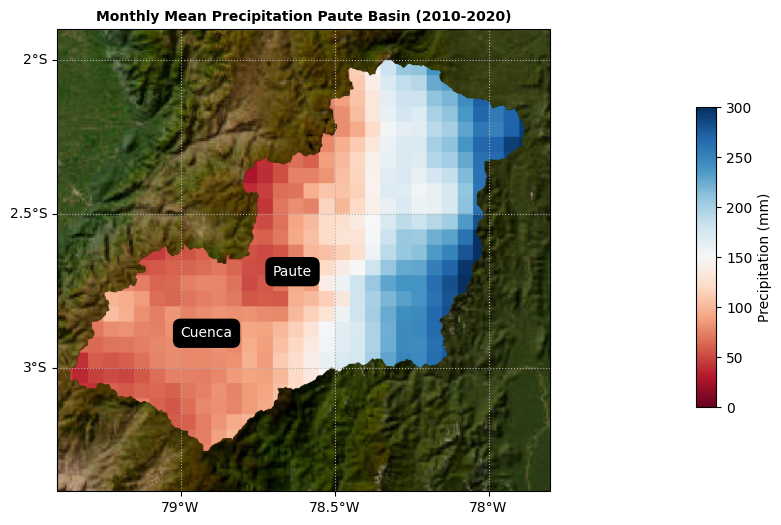

In [ ]:
#Reprojected_monthlyPrecip_mean = monthlyPrecip_mean.reproject(crs='EPSG:32717 ', scale=1000)

# set parameters for plotting
# will plot the image with specific range and colormap
visualization = {"bands": "precipitation", "min": 0, "max": 300}
# specify region to focus on
bbox = [-77.8, -3.4, -79.4, -1.9]

# Selext Open Street map BaseMap
#basemap= cimgt.OSM()

fig = plt.figure(figsize=(10, 6))

# plot the result with cartoee using a PlateCarre projection (default)
ax = cartoee.get_map(monthlyPrecip_mean, cmap="RdBu", vis_params=visualization, region=bbox, basemap="SATELLITE", zoom_level=8)
cb = cartoee.add_colorbar(ax, loc="right", cmap="RdBu", vis_params=visualization, label="Precipitation (mm)")


ax.set_title(label="Monthly Mean Precipitation Paute Basin (2010-2020)", fontsize=10, fontweight='bold')

# add the gridlines and specify that the xtick
cartoee.add_gridlines(ax, interval=0.5, xtick_rotation=0, linestyle=":")

# add a marker for Cuenca
ax.plot(-79, -2.9, 'ko')
ax.text(-79, -2.9, 'Cuenca', color='white', bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.5'))

# add a marker for Paute
ax.plot(-78.7, -2.7, 'ko')
ax.text(-78.7, -2.7, 'Paute', color='white', bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.5'))


In [ ]:
# Define CRS and transform manually
#crs = 'EPSG:4326'  # Example CRS (WGS 84)
#transform = [-77.8, -3.4, -79.4, -1.9]

In [ ]:
# Export the image, specifying the CRS, transform, and region.
#task = ee.batch.Export.image.toDrive(
#    image=fig,
#    description='Monthly_mean_precipitation',
#    crs=crs,
#    crsTransform=transform,
#    region=pauteBasin,
#)
#task.start()

Next, we'll create a time series of monthly precipitation. To do this, we'll calculate the spatial average of each image in the ImageCollection, which contains the monthly precipitation totals. This will result in a single monthly value that we'll use to create a bar plot time series.

To facilitate this process, we'll convert the images to features. This will allow us to transform the features into a GeoPandas DataFrame, making it easier to generate the plot.

In [ ]:
# Function to convert images into features
def image_to_feature(image):
    # Extract statistics from the image
    mean = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=pauteBasin,
        scale=5500
    )
    # Create a Feature with the statistics
    feature = ee.Feature(None, mean).set('id', image.id())
    return feature

# Explicitly convert the collection to features
feature_collection = ee.FeatureCollection(monthlyPrecip.map(image_to_feature))

# Use geemap to export to GeoDataFrame
Precip_gdf = geemap.ee_to_gdf(feature_collection, columns=None, sort_columns=False)

# Check the result
Precip_gdf

geometry   id  precipitation
0       None    0      89.109824
1       None    1     158.829759
2       None    2     142.742681
3       None    3     144.763084
4       None    4     223.770274
..       ...  ...            ...
127     None  127     137.899337
128     None  128      92.040837
129     None  129      75.530120
130     None  130      90.245260
131     None  131     161.511613

[132 rows x 3 columns]

In [ ]:
Precip_gdf.describe()

precipitation
count     132.000000
mean      136.041233
std        57.057533
min        44.698546
25%        91.891716
50%       124.083770
75%       171.417948
max       321.772230

In [ ]:
# Get basic info
count = monthlyPrecip.size().getInfo()
first_image = ee.Image(monthlyPrecip.first())
#first_date = first_image.date().format('YYYY-MM-dd').getInfo()
#last_image = ee.Image(monthlyPrecip.sort('system:time_start', False).first())
#last_date = last_image.date().format('YYYY-MM-dd').getInfo()

# Print results
print(f"Number of images: {count}")
#print(f"Date range: {first_date} to {last_date}")

# Get band information
bands = monthlyPrecip.first().bandNames().getInfo()
print(f"Bands: {bands}")

# Example: Print properties of the first image
print("First image properties:")
print(first_image.getInfo())

Number of images: 132
Bands: ['precipitation']
First image properties:
{'type': 'Image', 'bands': [{'id': 'precipitation', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}], 'properties': {'system:time_start': {'type': 'Date', 'value': 1262304000000}, 'month': 1, 'year': 2010, 'system:index': '0'}}


In [ ]:
# Convert the ee.List to Python lists
years = years_ee.getInfo()
months = months_ee.getInfo()

In [ ]:
# Add 'year' and 'month' columns using a lambda function
Precip_gdf['year'] = list(map(lambda y: y, [year for year in years for _ in months]))
Precip_gdf['month'] = list(map(lambda m: m, months * len(years)))

In [ ]:
# Drop unnecessary columns
Precip_gdf = Precip_gdf.drop(columns=["geometry", "id"])
Precip_gdf

precipitation  year  month
0        89.109824  2010      1
1       158.829759  2010      2
2       142.742681  2010      3
3       144.763084  2010      4
4       223.770274  2010      5
..             ...   ...    ...
127     137.899337  2020      8
128      92.040837  2020      9
129      75.530120  2020     10
130      90.245260  2020     11
131     161.511613  2020     12

[132 rows x 3 columns]

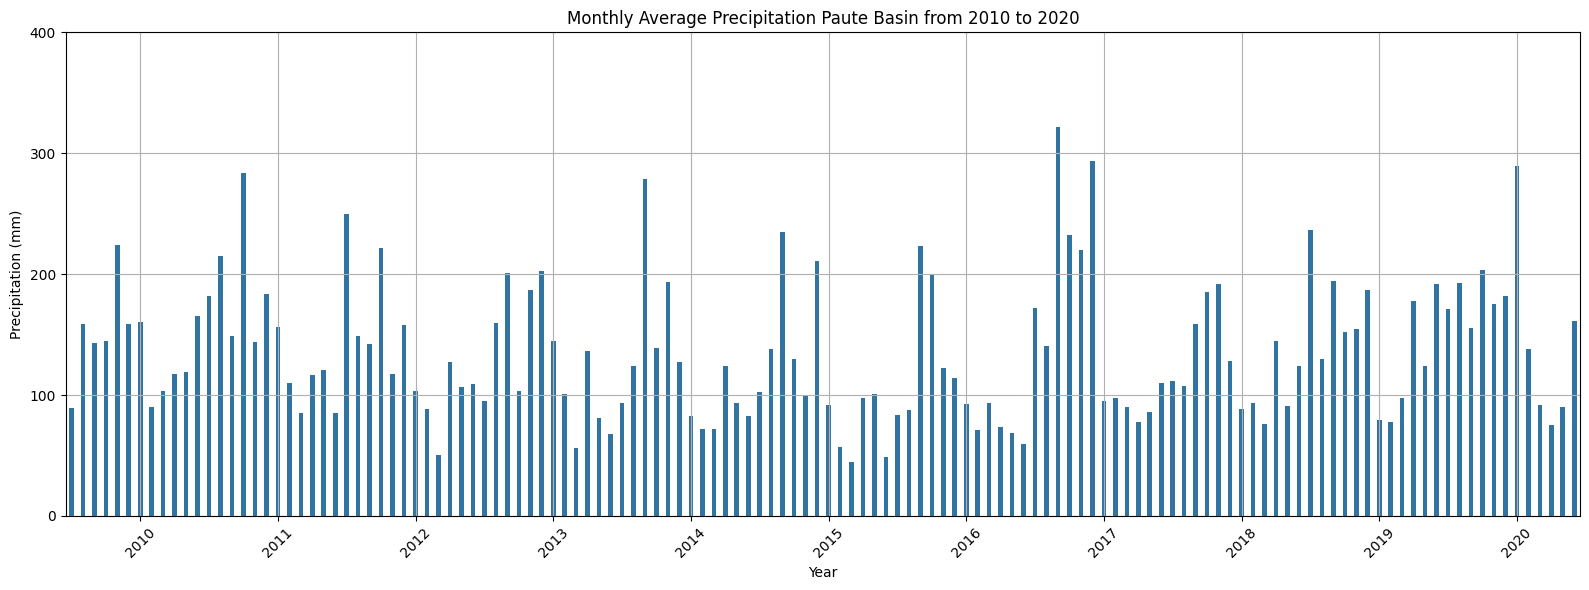

In [ ]:
# Create the 'time' column as a combination of 'year' and 'month' for grouping
Precip_gdf['time'] = Precip_gdf['year'].astype(str) + '-' + Precip_gdf['month'].astype(str)

# Plotting the bar plot
plt.figure(figsize=(16, 6))

# Create the bar plot
sns.barplot(x='time', y='precipitation', data=Precip_gdf, width=0.4)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Precipitation (mm)')
plt.title('Monthly Average Precipitation Paute Basin from 2010 to 2020')

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Get the list of years from 1981 to 2023
#years = list(range(1981, 2024))

# Get the list of years from 2010 to 2020
years = list(range(2010, 2021))

# Calculate positions for x-axis ticks and labels, adding separation between years
#year_labels = [str(year) for year in years]
#ticks = [i * 12 + 6 for i in range(len(years))]  # Place labels in the middle of each 12-month group

# Calculate positions for x-axis ticks and labels, adding separation between years
year_labels = [str(year) for year in years]
ticks = [i * 12 + 6 for i in range(len(years))]  # Place labels in the middle of each 12-month group

# Adjust spacing between groups of 12 bars by modifying the tick positions
plt.xticks(ticks=ticks, labels=year_labels)

# Adjust yticks spacing
plt.yticks(np.arange(0, 401, 100))

# Add gridlines
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

## Section 2: Calculating Monthly Evapotranspiration (ET)

We'll leverage the MOD16 product, a readily available ET product that utilizes daily meteorological reanalysis data and eight-day remote sensing observations of vegetation dynamics.

MOD16 typically provides data from 2000 to the present. After assessing data availability, we've set the analysis period from 2010 to 2020 and will replicate the analyses conducted for precipitation.



In [ ]:
# Import the MOD16 dataset.
mod16 = ee.ImageCollection('MODIS/006/MOD16A2').select('ET');

# Filter for the relevant time period.
mod16 = mod16.filterDate(startDate, endDate)

In [ ]:
mod16

We employ the same function as in the previous section to calculate monthly values. However, we multiply the results by 0.1, a scaling factor provided in the Earth Engine dataset description. Scaling factors are used to reduce storage requirements by adjusting the data type.

In [ ]:
# The function returns an image with the total (sum) evapotranspiration for each month
monthlyEvap = ee.ImageCollection.fromImages(
    years_ee.map(lambda y:
        months_ee.map(lambda m:
            ee.Image(mod16
                .filter(ee.Filter.calendarRange(y, y, 'year'))
                .filter(ee.Filter.calendarRange(m, m, 'month'))
                .sum()
                .multiply(0.1)
                .set('year', y)
                .set('month', m)
                .set('system:time_start', ee.Date.fromYMD(y, m, 1))
            )
        )
    ).flatten()
)

In [ ]:
monthlyEvap

In [ ]:
monthlyEvap_mean = monthlyEvap.mean().clip(pauteBasin)

# Use reduceRegion to calculate the min and max
stats = monthlyEvap_mean.reduceRegion(
    reducer=ee.Reducer.minMax(),  # Reducer to get min and max
    geometry=pauteBasin,                 # Specify the ROI
    scale=500,                   # Scale in meters
    maxPixels=1e9                 # Maximum number of pixels to process
)

# Get the results as a dictionary
min_max = stats.getInfo()

# Print the min and max values
print('Min and Max values:', min_max)

Min and Max values: {'ET_max': 83.590350877193, 'ET_min': 14.938461538461535}


In [ ]:
evapVis = {
    'min': 15,
    'max':85,
    'palette': ['yellow', 'blue']  # Yellow indicating low ET and blue indicating high ET.
}

# Initialize the map
Map = geemap.Map()
Map.centerObject(pauteBasin, zoom=8)

# Add the precipitation layer
Map.addLayer(
    monthlyEvap_mean,
    evapVis,
    'Evapotranspiration'
)

# Add a legend to the map (workaround to display the same information)
legend_dict = {
    'Blue (85 mm)': '#0000FF',
    'Yellow (15 mm)': '#FFFF00',
}
Map.add_legend(title="Mean Evapotranspiration (mm)", legend_dict=legend_dict)

# Display the map
Map

Map(center=[-2.6561001766080143, -78.56026731888969], controls=(WidgetControl(options=['position', 'transparen…

Text(-78.7, -2.7, 'Paute')

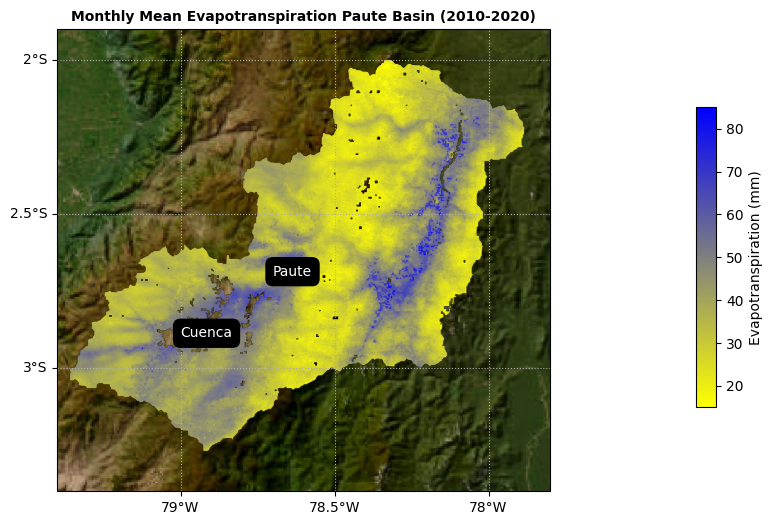

In [ ]:
# set parameters for plotting
# will plot the image with specific range and colormap
visualization = {"bands": "ET", "min": 15, "max": 85}
# specify region to focus on
bbox = [-77.8, -3.4, -79.4, -1.9]

# Selext Open Street map BaseMap
#basemap= cimgt.OSM()

fig = plt.figure(figsize=(10, 6))

# Define a custom color palette
palette = ['#ffff00', '#0000ff']  # Yellow to Blue

# Create visualization parameters
vis_params = {'min': 15, 'max': 85, 'palette': palette}

# Add the layer to the map
ax = cartoee.get_map(monthlyEvap_mean, vis_params=vis_params, region=bbox, basemap="SATELLITE", zoom_level=8)

# Add a colorbar
cb = cartoee.add_colorbar(ax, loc="right", vis_params=vis_params, label="Evapotranspiration (mm)")

# Adds tittle
ax.set_title(label="Monthly Mean Evapotranspiration Paute Basin (2010-2020)", fontsize=10, fontweight='bold')

# add the gridlines and specify that the xtick
cartoee.add_gridlines(ax, interval=0.5, xtick_rotation=0, linestyle=":")

# add a marker for Cuenca
ax.plot(-79, -2.9, 'ko')
ax.text(-79, -2.9, 'Cuenca', color='white', bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.5'))

# add a marker for Paute
ax.plot(-78.7, -2.7, 'ko')
ax.text(-78.7, -2.7, 'Paute', color='white', bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.5'))

In [ ]:
# Function to convert images into features
def image_to_feature(image):
    # Extract statistics from the image
    mean = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=pauteBasin,
        scale=500
    )
    # Create a Feature with the statistics
    feature = ee.Feature(None, mean).set('id', image.id())
    return feature

# Explicitly convert the collection to features
Evap_feature_collection = ee.FeatureCollection(monthlyEvap.map(image_to_feature))

# Use geemap to export to GeoDataFrame
Evap_gdf = geemap.ee_to_gdf(Evap_feature_collection, columns=None, sort_columns=False)

# Check the result
Evap_gdf


geometry         ET   id
0       None  36.741368    0
1       None  29.104460    1
2       None  41.001205    2
3       None  24.806964    3
4       None  41.776983    4
..       ...        ...  ...
127     None  56.058280  127
128     None  46.678058  128
129     None  57.977884  129
130     None  32.824020  130
131     None  25.454510  131

[132 rows x 3 columns]

In [ ]:
# Add 'year' and 'month' columns using a lambda function
Evap_gdf['year'] = list(map(lambda y: y, [year for year in years for _ in months]))
Evap_gdf['month'] = list(map(lambda m: m, months * len(years)))

# Drop unnecessary columns
Evap_gdf = Evap_gdf.drop(columns=["geometry", "id"])

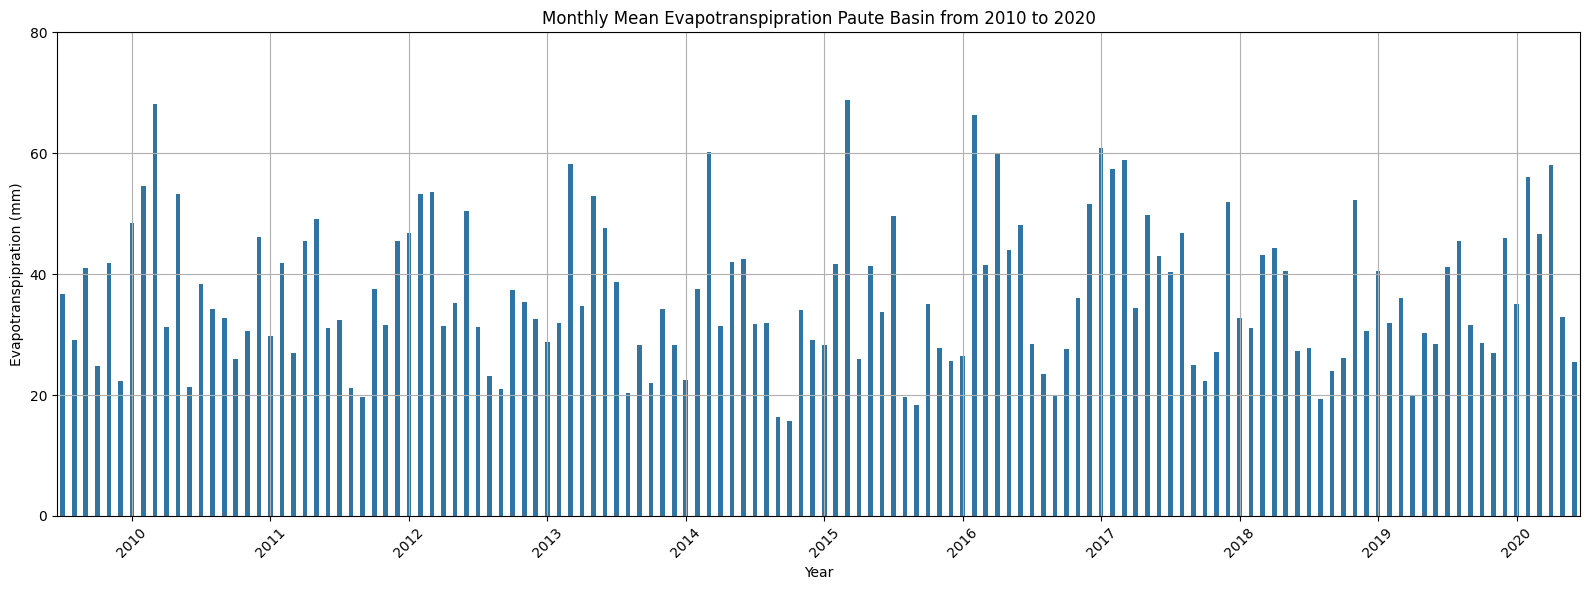

In [ ]:
# Create the 'time' column as a combination of 'year' and 'month' for grouping
Evap_gdf['time'] = Evap_gdf['year'].astype(str) + '-' + Evap_gdf['month'].astype(str)

# Plotting the bar plot
plt.figure(figsize=(16, 6))

# Create the bar plot
sns.barplot(x='time', y='ET', data=Evap_gdf, width=0.4)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Evapotranspipration (mm)')
plt.title('Monthly Mean Evapotranspipration Paute Basin from 2010 to 2020')

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Get the list of years from 2010 to 2020
years = list(range(2010, 2021))

# Calculate positions for x-axis ticks and labels, adding separation between years
year_labels = [str(year) for year in years]
ticks = [i * 12 + 6 for i in range(len(years))]  # Place labels in the middle of each 12-month group

# Adjust spacing between groups of 12 bars by modifying the tick positions
plt.xticks(ticks=ticks, labels=year_labels)

# Adjust yticks spacing
plt.yticks(np.arange(0, 81, 20))

# Add gridlines
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

## Section 3: Monthly water balance

### Calculating the Water Balance

We've previously calculated monthly precipitation (P) at a 5 km resolution and monthly evapotranspiration (ET) at a 500 m resolution. To determine the remaining components of the water balance equation (runoff, Q, and storage change, ΔS), we'll rearrange the equation as follows:

P - ET = Q + ΔS
In the next steps, we'll use the calculated P and ET values to estimate Q and ΔS on a pixel-by-pixel basis and then aggregate these values at the basin scale.



In [ ]:
def subtract_images(index):
  image1 = ee.Image(monthlyPrecip.toList(monthlyPrecip.size()).get(index))
  image2 = ee.Image(monthlyEvap.toList(monthlyEvap.size()).get(index))
  return image1.subtract(image2).rename('water_balance')

water_balance = ee.ImageCollection(ee.List.sequence(0, monthlyPrecip.size().subtract(1)).map(subtract_images))

In [ ]:
water_balance

In [ ]:
monthlyWB_mean = water_balance.mean().clip(pauteBasin)

# Use reduceRegion to calculate the min and max
stats = monthlyWB_mean.reduceRegion(
    reducer=ee.Reducer.minMax(),  # Reducer to get min and max
    geometry=pauteBasin,                 # Specify the ROI
    scale=500,                   # Scale in meters
    maxPixels=1e9                 # Maximum number of pixels to process
)

# Get the results as a dictionary
min_max = stats.getInfo()

# Print the min and max values
print('Min and Max values:', min_max)

Min and Max values: {'water_balance_max': 306.2907384607527, 'water_balance_min': -17.644734174446164}


In [ ]:
WBVis = {
    'min': -18,
    'max':300,
    'palette': ['yellow', 'blue']  # Yellow indicating low ET and blue indicating high ET.
}

# Initialize the map
Map = geemap.Map()
Map.centerObject(pauteBasin, zoom=8)

# Add the precipitation layer
Map.addLayer(
    monthlyWB_mean,
    WBVis,
    'Water Balance'
)

# Add a legend to the map (workaround to display the same information)
legend_dict = {
    'Blue (300 mm)': '#0000FF',
    'Yellow (-18 mm)': '#FFFF00',
}
Map.add_legend(title="Water Balance (mm)", legend_dict=legend_dict)

# Display the map
Map

Map(center=[-2.6561001766080143, -78.56026731888969], controls=(WidgetControl(options=['position', 'transparen…

Text(-78.7, -2.7, 'Paute')

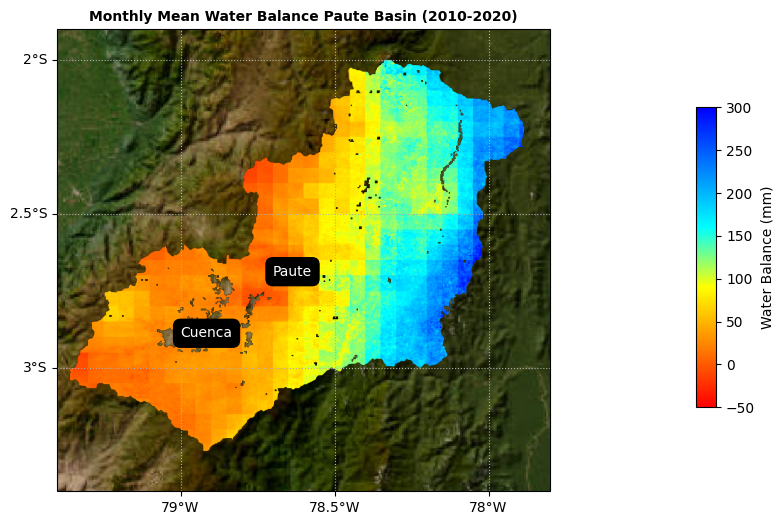

In [ ]:
# set parameters for plotting
# will plot the image with specific range and colormap
visualization = {"bands": "ET", "min": -18, "max": 300}
# specify region to focus on
bbox = [-77.8, -3.4, -79.4, -1.9]

# Selext Open Street map BaseMap
#basemap= cimgt.OSM()

fig = plt.figure(figsize=(10, 6))

# Define a custom color palette
# Define a custom color palette
#palette = ['#ffff00', '#0000ff']  # Yellow to Blue

# Define a diverging color palette
palette = ['#FF0000', '#FF7F00', '#FFFF00', '#00FFFF', '#007FFF', '#0000ff']

# Create visualization parameters
vis_params = {'min': -50,
              'max': 300,
              'palette': palette,
              }  # Custom tick values

# Add the layer to the map
ax = cartoee.get_map(monthlyWB_mean, vis_params=vis_params, region=bbox, basemap="SATELLITE", zoom_level=8)

# Add a colorbar
cb = cartoee.add_colorbar(ax, loc="right", vis_params=vis_params, label="Water Balance (mm)")

# Adds tittle
ax.set_title(label="Monthly Mean Water Balance Paute Basin (2010-2020)", fontsize=10, fontweight='bold')

# add the gridlines and specify that the xtick
cartoee.add_gridlines(ax, interval=0.5, xtick_rotation=0, linestyle=":")

# add a marker for Cuenca
ax.plot(-79, -2.9, 'ko')
ax.text(-79, -2.9, 'Cuenca', color='white', bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.5'))

# add a marker for Paute
ax.plot(-78.7, -2.7, 'ko')
ax.text(-78.7, -2.7, 'Paute', color='white', bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.5'))

In [ ]:
# Function to convert images into features
def image_to_feature(image):
    # Extract statistics from the image
    mean = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=pauteBasin,
        scale=500
    )
    # Create a Feature with the statistics
    feature = ee.Feature(None, mean).set('id', image.id())
    return feature

# Explicitly convert the collection to features
WB_feature_collection = ee.FeatureCollection(water_balance.map(image_to_feature))

# Use geemap to export to GeoDataFrame
WB_gdf = geemap.ee_to_gdf(WB_feature_collection, columns=None, sort_columns=False)

# Check the result
WB_gdf

geometry   id  water_balance
0       None    0      42.853697
1       None    1     111.197956
2       None    2      85.874548
3       None    3     111.588748
4       None    4     151.222955
..       ...  ...            ...
127     None  127      75.703657
128     None  128      41.984220
129     None  129      13.388434
130     None  130      58.223988
131     None  131     114.879140

[132 rows x 3 columns]

In [ ]:
# Add 'year' and 'month' columns using a lambda function
WB_gdf['year'] = list(map(lambda y: y, [year for year in years for _ in months]))
WB_gdf['month'] = list(map(lambda m: m, months * len(years)))

# Drop unnecessary columns
WB_gdf = WB_gdf.drop(columns=["geometry", "id"])

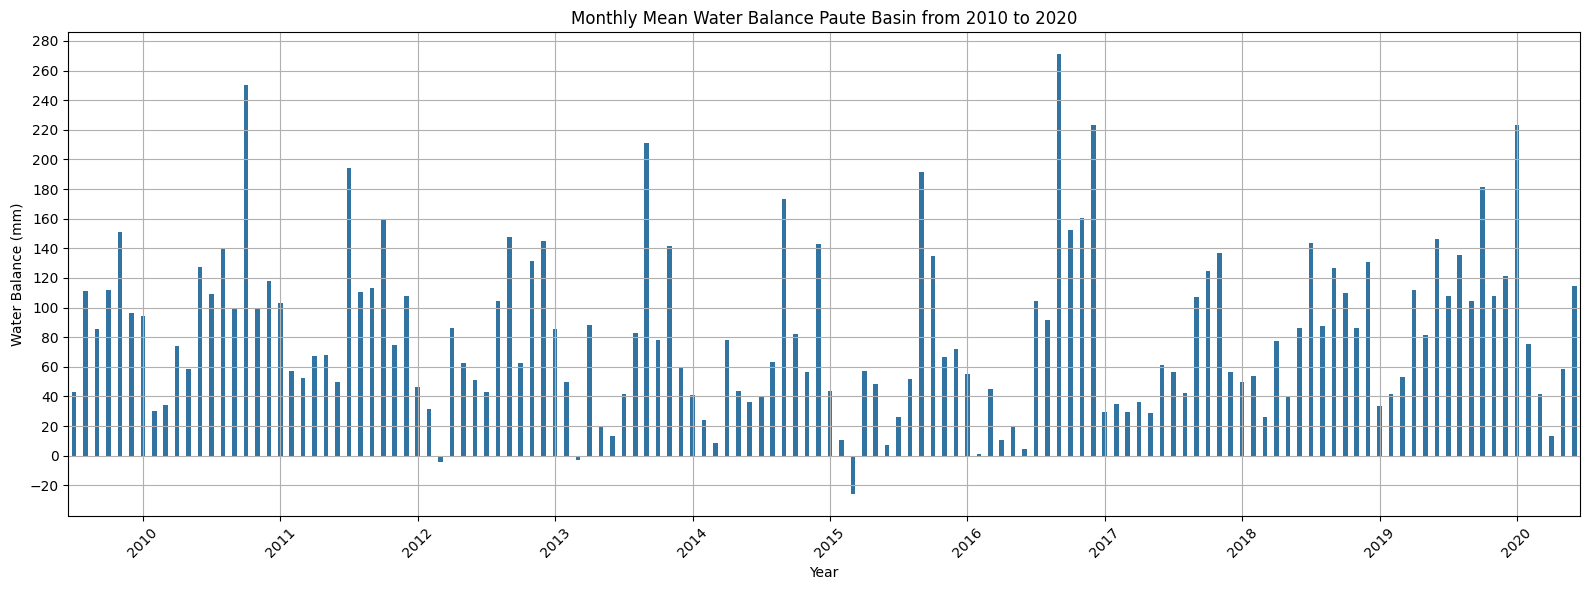

In [ ]:
# Create the 'time' column as a combination of 'year' and 'month' for grouping
WB_gdf['time'] = WB_gdf['year'].astype(str) + '-' + WB_gdf['month'].astype(str)

# Plotting the bar plot
plt.figure(figsize=(16, 6))

# Create the bar plot
sns.barplot(x='time', y='water_balance', data=WB_gdf, width=0.4)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Water Balance (mm)')
plt.title('Monthly Mean Water Balance Paute Basin from 2010 to 2020')

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Get the list of years from 2010 to 2020
years = list(range(2010, 2021))

# Calculate positions for x-axis ticks and labels, adding separation between years
year_labels = [str(year) for year in years]
ticks = [i * 12 + 6 for i in range(len(years))]  # Place labels in the middle of each 12-month group

# Adjust spacing between groups of 12 bars by modifying the tick positions
plt.xticks(ticks=ticks, labels=year_labels)

# Adjust yticks spacing
plt.yticks(np.arange(-20, 300, 20))

# Add gridlines
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()